Loading intrinsic population


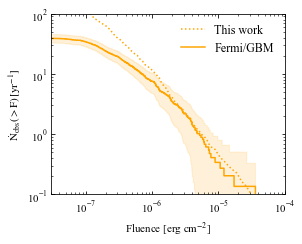

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas
import warnings
warnings.filterwarnings("ignore")
from functions_ET import * 

def plot_cumulative_fermi(data, column_name):
    dates = data['name'].str.extract(r'GRB(\d{2})(\d{2})(\d{2})')
    dates = pandas.to_datetime('20' + dates[0] + '-' + dates[1] + '-' + dates[2], format='%Y-%m-%d', errors='coerce')
    data = data[~dates.isna()]
    years_span = (dates.max() - dates.min()).days / 365.25
    data = data.dropna(subset=[column_name, f"{column_name}_error"])
    short = data['t90'] <= 2.
    flux = data[column_name].loc[short]
    flux_err = data[f"{column_name}_error"].loc[short]
    cumulative_counts = np.arange(len(flux))
    flux_sampled = np.array(flux).reshape([1, len(flux)]) * (
        np.random.lognormal(
            mean=np.zeros_like(flux_err), 
            sigma=np.log((1. + (flux_err / flux)**2)**0.5),
            size=[1000, len(flux)]
        )
    )
    sorted_indices = np.argsort(flux)
    cumulative_sampled = np.zeros([1000, len(flux)])
    for i in range(1000):
        cumulative_sampled[i] = np.interp(
            flux.iloc[sorted_indices],
            np.sort(flux_sampled[i]),
            np.random.poisson(cumulative_counts)
        )
    lower_percentile = np.percentile(cumulative_sampled, 5., axis=0)
    upper_percentile = np.percentile(cumulative_sampled, 95., axis=0)
    return {
        'x': flux.iloc[sorted_indices[::-1]],
        'y_median': cumulative_counts / years_span,
        'y_lower': lower_percentile / years_span,
        'y_upper': upper_percentile / years_span,
        'years_span': years_span,
    }

def plot_cumulative_fluence_bol(data, column_name):
    dates = data['name'].str.extract(r'GRB(\d{2})(\d{2})(\d{2})')
    dates = pandas.to_datetime('20' + dates[0] + '-' + dates[1] + '-' + dates[2], format='%Y-%m-%d', errors='coerce')
    data = data[~dates.isna()]
    years_span = (dates.max() - dates.min()).days / 365.25
    short_grb = data[data['t90'] <= 2]
    fluence = short_grb[column_name].dropna()
    fluence_sorted = np.sort(fluence)[::-1]
    cumulative_counts = np.arange(1, len(fluence_sorted) + 1) / years_span
    lower_error = cumulative_counts - np.sqrt(cumulative_counts)
    upper_error = cumulative_counts + np.sqrt(cumulative_counts)
    return {
        'x': fluence_sorted,
        'y_median': cumulative_counts,
        'lower_error': lower_error,
        'upper_error': upper_error,
        'years_span': years_span,
    }

plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.figsize'] = 4.3, 3.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["axes.axisbelow"] = False

num = 1000000
eos = "SFHo"
mns_max = 2.058838

table = h5py.File(f'../horizons2/population/computed_population/nsns_{num}_{eos}_GWFAST.hdf5', 'r') #change this line

print("Loading intrinsic population")
m1 = table['m1'][()]
m2 = table['m2'][()]
z = table['z'][()]
thv = table['thv'][()]
m_dyn = table['m_dyn'][()]
m_disk = table['m_disk'][()]
m_gw = table['m_gw'][()]
flux_prompt = table['flux_prompt'][()]
flux_prompt_alpha = table['flux_prompt_alpha'][()]
fluence_prompt = table['fluence_prompt'][()]
bol_fluence_prompt = table['bol_fluence_prompt'][()]
table.close()

flux_prompt *= (0.1 / 0.15) * (0.015 / 0.022)
flux_prompt_alpha *= (0.1 / 0.15) * (0.015 / 0.022)

fluence_prompt_10_1000 = flux_prompt[:, 0] * 2 * (1 + z)
fluence_prompt_50_300 = flux_prompt[:, 2] * 2 * (1 + z)

w_thv = np.sin(thv)
w_m1, w_m2 = mass_colombo22(m1, m2)
r0BNS = 347 / 1.85
r0BNS_high = (347 + 536) / 1.85
r0BNS_low = (347 - 256) / 1.85 
w_z, w_z_high, w_z_low = redshift_weight(z, r0BNS, r0BNS_high, r0BNS_low)
w = w_m1 * w_m2 * w_z * w_thv
w_high = w_m1 * w_m2 * w_z_high * w_thv
w_low = w_m1 * w_m2 * w_z_low * w_thv
C_mc, C_mc_high, C_mc_low = monte_carlo_normalization(w, w_high, w_low, r0BNS, r0BNS_high, r0BNS_low)

logS_flu = np.logspace(-8, -4, 100)
logN_bol = np.zeros(len(logS_flu))
m_rem = m1 + m2 - m_gw - m_disk - m_dyn

for i in range(len(logS_flu)):
    logN_bol[i] = np.sum(w[(bol_fluence_prompt[:] >= logS_flu[i]) & (m_rem > 1.2 * mns_max) & (m_disk > 1.e-5)])

duty_fermi = 0.6
plt.plot(logS_flu, C_mc * logN_bol * duty_fermi, ls=":", color="orange", label="This work")

data_bol = pandas.read_csv('./prompt_data/grb_fluence_bolometric.txt', delim_whitespace=True)
fluence_bol = plot_cumulative_fluence_bol(data_bol, 'flnc_bol')
plt.step(fluence_bol['x'], fluence_bol['y_median'], 'orange', label="Fermi/GBM")
plt.fill_between(fluence_bol['x'], fluence_bol['lower_error'], fluence_bol['upper_error'], alpha=0.15, color="orange", step='mid')

plt.legend(frameon=False, prop={'size': 12})
plt.xlabel(r'Fluence [erg $\mathrm{cm}^{-2}$]', size=11)
plt.ylabel(r'$\dot \mathrm{N}_\mathrm{obs}(>\mathrm{F}) \,[\mathrm{yr}^{-1}]$', size=11)
plt.xlim(3e-8, 1e-4)
plt.ylim(1e-1, 1.e2)
plt.tick_params(direction='in', which='both', left=True, bottom=True, top=True, right=True, labelsize=11)
plt.loglog()
plt.show()